# This notebook

Note: installing neuron was not that straightforward.





In [65]:
import argparse
import numpy as np
import datetime
import pickle 
import warnings
import neuron
import sys
import csv
#! echo $PYTHONPATH

In [2]:
%run BREPpy.py

#Todo: Read in from command line for int or bool parameters.
b = Brep()
b.init_from_script(['--config_fn','./input_files/Parameters.hoc'])
b.read_in_config()

### Parsing the Parameter file
Not nice: there are about 4 different names for one variable- there are the default ones in the code, the assigned ones in the code, and the ones in the parameter file. 
I will use variables that are similar to the ones defined in the grammar in the code, with the difference that they will be adapted to Python syntax ( _ instead of -), and a few have an additional postfix to clarify what they do (e.g. \_fn = filename) 


### On the installation of neuron
Neuron did not really work out of the box for me. 
I (ubuntu 16.04 LTS, 64 bit) did it the following way:
- Download the .rpm package from here: https://www.neuron.yale.edu/neuron/download
- Install it with: 
    `alien -i nrn_...*package*` (Note that the .deb package did not work out, and neither did the installation using rpm directly)
- Edit the .bashrc file by adding the following lines: 

    `#Added for neuron
    export PYTHONPATH="${PYTHONPATH}:/usr/local/nrn/lib/python/" `
    
    (first check that this path is actually where it got installed by going to the folder and see whether `python -c 'import neuron'` tells you about your NEURON version or whether there ain't no module called neuron.


http://www.davison.webfactional.com/notes/hoc-to-python-bulbnet/

## Checking out the output of the original BREP program.

In [210]:
##filenames and input paths for the different files.
import os
from collections import OrderedDict
res_p = os.path.normpath(os.getcwd()+'/output_1/')

fns = OrderedDict ()
fns['aa_gol_dist']='AAtoGoCdistances.dat'
fns['aa_gol_segs']='AAtoGoCsegments.dat'
fns['aa_gol_source']='AAtoGoCsources.dat'
fns['aa_gol_target']='AAtoGoCtargets.dat'

fns['gran_coord'] ='GCcoordinates.sorted.dat'       
fns['gran_t_coord']='GCTcoordinates.sorted.dat'
    
fns['go_coord']='GoCcoordinates.sorted.dat'
fns['go_basd_coord']='GoCbdendcoordinates.sorted.dat'
fns['go_apical_coord']='GoCadendcoordinates.sorted.dat'
fns['go_axon_coord']='GoCaxoncoordinates.sorted.dat'
fns['go_dist']='GoCdistances.dat' #
       
fns['go_go_dist']='GoCtoGoCdistances.dat'
fns['go_go_sources']='GoCtoGoCsources.dat'
fns['go_go_targets']='GoCtoGoCtargets.dat'
fns['go_go_gap_dist']='GoCtoGoCgapdistances.dat'
fns['go_go_gap_source']='GoCtoGoCgapsources.dat'
fns['go_go_gap_target']='GoCtoGoCgaptargets.dat'

fns['pf_go_dist']='PFtoGoCdistances.dat'
fns['pf_go_seg']='PFtoGoCsegments.dat'
fns['pf_go_source']='PFtoGoCsources.dat'
fns['pf_go_target']='PFtoGoCtargets.dat'

#for k,v in fns.items():
##    print (k)
#a = import_csv(in_f)
#rr = read_in_coordfile (in_goba)

In [397]:

#def import_csv (fn):
def read_in_coordfile (fn, parse_ignore = True):
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    return np.asarray(res)

#rr = read_in_coordfile(fn)

In [471]:
# Visualize Golgi cells
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#read in
coord = read_in_coordfile(res_p +'/'+fns['go_coord'])
apical = read_in_coordfile(res_p +'/'+fns['go_apical_coord'])
basal = read_in_coordfile(res_p +'/'+fns['go_basd_coord'])
axon = read_in_coordfile(res_p +'/'+fns['go_axon_coord'])
new_ap = read_in_coordfile('new_apical.dat', parse_ignore=False)
new_bas = read_in_coordfile('new_basal.dat', parse_ignore=False)
new_ax = read_in_coordfile('new_axon.dat', parse_ignore=False)


#reshape
def coord_reshape (dat):
    dat = dat.reshape([dat.shape[0], int(dat.shape[1]/3),3])
    return dat


apical = apical.reshape([apical.shape[0],int(apical.shape[1]/3),3])
basal = basal.reshape([basal.shape[0],int(basal.shape[1]/3),3])
axon = axon.reshape([axon.shape[0],int(axon.shape[1]/3),3])
print (axon.shape)
new_ap = coord_reshape(new_ap)
new_bas = coord_reshape(new_bas)
print( new_ax.shape)
new_ax = coord_reshape(new_ax)
print (new_ax.shape)

(200, 40, 3)
(200, 120)
(200, 40, 3)


In [470]:
ax_x = [-45, 45]
ax_y = [-160, 160]
ax_z = [-75, 75]
n_pts = 40

def generate_axon (coord, ax_x, ax_y, ax_z, n_pts):
    res = []
    for j in range(len(coord)):
        ar = np.random.uniform(size = [n_pts, 3])
        for i, [low, high] in enumerate([ax_x, ax_y, ax_z]):
            ar[:,i] = ar[:,i]*(high-low)+low+coord[j,i]
        ar[0,:] = (coord[j,:]) # include point of soma (as done in the original BREP)
        res.append(ar.ravel())
    return np.asarray(res)

my_ax = generate_axon (coord, ax_x, ax_y, ax_z, n_pts)
np.savetxt('new_axon.dat', my_ax , delimiter=' ')



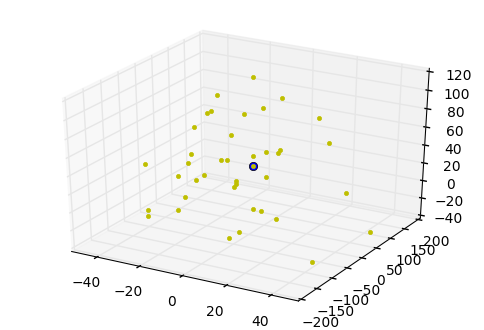

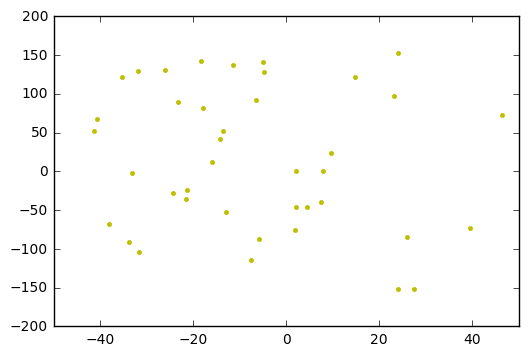

In [472]:
# plot
ns = np.arange(1) #neurons to be plotted.

plot_somata = True
plot_apical = 0
plot_basal = 0
plot_axon = 0
plot_new_ap = 0
plot_new_bas  = 0
plot_new_ax = 1
overlay = 0

options= [
    (apical, plot_apical, 'kx'),
    (basal, plot_basal, 'gx'), 
    (axon, plot_axon, 'r.'), 
    (new_ap, plot_new_ap, 'cx'),
    (new_bas, plot_new_bas, 'mx'),
    (new_ax, plot_new_ax, 'y.')]


fig = plt.figure()
ax = fig.gca(projection='3d')
if plot_somata: 
    if not overlay: ax.plot(coord[ns,0], coord[ns,1], coord[ns,2], 'bo')
    else: ax.plot ([0],[0],[0],'bo')

#plot dendrites and axon.
for pts, yn, col in options:
    for i in ns:
        if yn:
            if overlay: pt = pts[i,:,:]-coord[i,:]
            else: pt = pts[i,:,:]
            ax.plot(pt[:,0], pt[:,1], pt[:,2], col)

#ax.view_init(30,180)
proj2D = True
if proj2D:
    plt.figure()
    for pts, yn, col in options:
        for i in ns:
            if yn:
                if overlay: pt = pts[i,:,:]-coord[i,:]
                else: pt = pts[i,:,:]
                plt.plot(pt[:,0], pt[:,1], col)

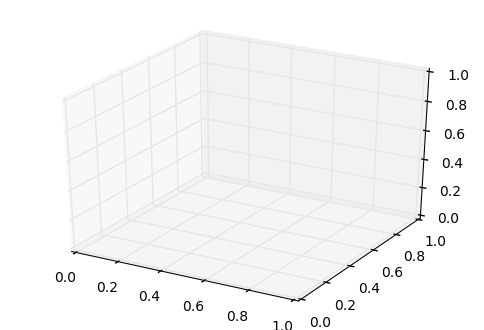

In [427]:
a_h = 332.0
a_r= 100.0
b_h = -6.0
b_r = 60.0
a_m = [30.0, 120.0]
b_m = [-20.0, -240.0]
b_std = 10.0
a_std = 10.0
a_sp = 7.5
b_sp = 7.5


som = coord


def gen_dendrites (som, c_r, c_h, c_m, c_std, c_sp, col, plot_fig = False):
    c_n = int(np.linalg.norm([c_r, c_h])/c_sp)
    c_gr = np.linspace(0,1,c_n)*np.ones((3, c_n))
    b_res = []
    for i in range(len(som)):
        som_c = som[i,:]
        d_res = []
        for cc_m in c_m:
            ep_ang = (np.random.randn()*c_std + cc_m)*np.pi/180
            pt = ([np.sin(ep_ang)*c_r, np.cos(ep_ang)*c_r, c_h])*c_gr.T
            if plot_fig: ax.plot(pt[:,0], pt[:,1], pt[:,2], col);
            d_res.append(pt+som_c)
        b_res.append(d_res)
    return b_res

def dend_to_file_format (dend, save = True):
    dd = np.asarray([np.ravel(np.concatenate((dend[i][0], dend[i][1]))) for i in range(len(dend))])
    return dd
    
a_dend = gen_dendrites(som, a_r, a_h, a_m, a_std, a_sp, 'gx')
b_dend = gen_dendrites(som, b_r, b_h, b_m, b_std, b_sp, 'kx')

af = (dend_to_file_format(a_dend))
np.savetxt('new_apical.dat', af, delimiter=' ')

bf = (dend_to_file_format(b_dend))
np.savetxt('new_basal.dat', bf, delimiter=' ')




In [428]:
res = np.zeros((40000, 3))
for i in range(200):
    for j in range(200):
        res[i*200+j,:] = coord[i,:]-coord[j,:]
#dist = [coord[i,:]-coord[j,:] for i,j in range(200)]
dist = read_in_coordfile(res_p +'/'+fns['go_dist'])

print (dist)
print (np.round(-res))
#print (res[1:100,:] + dist[:99,:])
#the distances file just contains all possible differences betwween the different Golgi cells, rounded in an inconsistant way.

[[   0.            1.          142.09308533]
 [   0.            2.          157.44978905]
 [   0.            3.           43.12415203]
 ..., 
 [ 199.          196.           65.79048276]
 [ 199.          197.           95.59447442]
 [ 199.          198.           17.75951662]]
[[  -0.   -0.   -0.]
 [  -1.    0.  142.]
 [  -1.    0.  157.]
 ..., 
 [   3.   -0.   96.]
 [   3.   -0.  -18.]
 [  -0.   -0.   -0.]]


In [250]:
## golgi-golgi interactions
src = read_in_coordfile(res_p +'/'+fns['go_go_sources'])
tar = read_in_coordfile(res_p +'/'+fns['go_go_targets'])
dis = read_in_coordfile(res_p +'/'+fns['go_go_dist'])

res_n = np.zeros(100)
for i in range(100):
    #res_n[i] = np.linalg.norm(coord[int(tar[i]),:]-coord[int(src[i]),:])
    res_n[i] = (sum((coord[int(tar[i]),:]-coord[int(src[i]),:])**2)**0.5)

import networkx as nx+
print (res_n)
print (dis[:-100])

[  56.31006333  113.8559862   110.4045377    15.34303723  107.9276772
   94.27480316   56.04726051   59.50642166   38.07129959   76.36443417
   47.9885867    54.73232036    9.8691233    65.98634018   41.88766941
   58.04680016  112.99076202   15.5543146   119.87818485   10.0483928
  103.291404     16.35245464   94.02119516   67.55205461   18.50082904
   15.22664819  115.69709246  109.09285366    0.82075037   11.9595946
   25.85390636   36.21259885   33.85475679    3.03820216   40.04966157
   43.23773634   24.74031385   65.69946128   38.12732945   62.91163291
   14.74542281   35.99190708   37.27495948   13.13174009   50.95825049
   79.06989875  112.50682176   65.79048276  117.48522206    9.22962467
   53.59530878   99.70743204   64.50728449   20.58380682   93.81356417
   95.59447442   18.17589638  112.47734432   19.9397943    16.30913634
   61.08593857   35.55643808   22.26225624   36.79938365   22.50878582
    5.85895196   26.49809677   93.45842923   45.28039136   12.95481222
   38.665

In [414]:
for k, v in fns.items():
    #print ('Read in file: ', v)
    c_p = os.getcwd()+'/output_1/'+v
    cur = read_in_coordfile(c_p)
    
    c_p2 = os.getcwd()+'/output_2/'+v
    cur2 = read_in_coordfile(c_p2)

    #print ('Shape 1 is: ', cur.shape)
    #print ('Shape 2 is: ', cur2.shape)
    
    #print ('First elements in 1 are:', cur.flatten()[:15])
    #print ('First elements in 2 are:', cur2.flatten()[:15])
    
    #print (' ')

KeyboardInterrupt: 

On kd-Trees:
- binary search stree
    - every branching node contains a k-dimensional point
    - every leaf node contains a set of points
- every branching node represents a splitting hyperplane that divides the space into two half-spaces    
    - left of the splitting hyperplane = left subtree, same for richt
    - each spliitting hyperplane is perpendicular to one of the axes in the k-dimensional space
    - the axes for the splitting hyperplanes are rotating

On the chicken kd-tree library:
- works with datastructure POINT3D
    - constructor: make-point3d dbl dbl dbl 
    - accessors point3d-x /y/z
    - predicate: point3d?
- KD-Tree itself
    - constructor: list->kd-tree (list of POINT3D)
    - predicates: kd-tree? -> checks object, kd-tree-empty?, 
        - kd-tree-is-valid? -> checks if all points in subtree lie on left side of hyperplane and right on right
        - kd-tree-all-subtrees-are-valid? -> valid property for all branching nodes?
    - accessors: 
        - kd-tree->list  -> all the points contained in tree in a POINT3D list
        - kd-tree->list\* -> list with elements of the form (i . POINT3D) -> i is the relative integer index of the point
     
for other accessors, the author was not motivated enough to write a description.


In [132]:
print (rr.shape)
ri = rr[:,0]
ro = rr[0,:]

import matplotlib.pyplot as plt
%matplotlib inline
for j in range(3):
    plt.figure()
    for i in range(len(rr)):
        g = rr[i,:].reshape([50,3])
        plt.plot(g[:25,j])
        plt.plot(g[25:,j])
        
plt.figure()
for i in range(len(rr)):
    g = rr[i,:].reshape([50,3])
    plt.plot(g[24,0], g[24,1], 'kx')
    plt.plot(g[49,0], g[49,1], 'rx')

(200, 72)


ValueError: cannot reshape array of size 72 into shape (50,3)

### Checking out the kd-tree libraries

Scipy:
- Documentation: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html
- Source Code: https://github.com/scipy/scipy/blob/master/scipy/spatial/kdtree.py
- Algorithm reference Maneewongvatana and Mount 1999
- Can be queried for r nearest neighbors, however r should be relatively small because elsewise, brute force is just as efficient.
- Approximate nearest neighbors seems to be another, and much faster option, and might work well for us.
- Uses pythonic libraries. 
- The heap queue algorithm: https://github.com/python/cpython/blob/2.7/Lib/heapq.py seems to be used, but it is also in python


SKlearn:
- Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html
- Source Code: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/kd_tree.pyx
- uses cython. Might thus be faster. Let's check.


Neither of them appears to have parallelization supported right from the beginning.
Both just take regular arrays as inputs.


Could be interesting:
http://ieeexplore.ieee.org/abstract/document/5654017/?reload=true
GPU implementation for kNN search
Following this:
https://link.springer.com/chapter/10.1007/978-3-642-38628-2_67



In [50]:
from scipy.spatial import KDTree as T_sp
from sklearn.neighbors import KDTree as T_sk
s_dat = np.asarray(import_csv(fn_out))
import time

rn = np.random.randint(0, len(s_dat), 50)
nn = 10

In [51]:
print (s_dat.shape)

(798000, 3)


In [60]:
k_dist = np.zeros((len(rn), nn))
k_ind = np.zeros((len(rn), nn))
tk0 = time.time()
kt = T_sk(s_dat)
tk1 = time.time()
for i, ii in enumerate(rn):
    warnings.simplefilter('ignore') #definitely not ideal. But no clue how the validation file gets called
    k_dist[i,:], k_ind [i,:] = kt.query(s_dat[ii,:], k = nn)
tk2 = time.time()

In [410]:



import pickle as pkl
'''with open ('new_apical2.dat', 'wb', newline = '') as f_out:
    wr = csv.writer(f_out, delimiter = ' ')
    ff = dend_to_file_format(a_dend)
    for row in ff:
        print (row)
        wr.writerow([ff[i,j] for j in range(len(ff[i,:]))])
        
ff.T.tofile('new_apical.dat',sep=' ',format='%10.5f')
'''

(10, 276)
(10, 92, 3)


"with open ('new_apical2.dat', 'wb', newline = '') as f_out:\n    wr = csv.writer(f_out, delimiter = ' ')\n    ff = dend_to_file_format(a_dend)\n    for row in ff:\n        print (row)\n        wr.writerow([ff[i,j] for j in range(len(ff[i,:]))])"

In [53]:
p_dist = np.zeros((len(rn), nn))
p_ind = np.zeros((len(rn), nn))
tp0 = time.time()
pt = T_sp(s_dat)
tp1 = time.time()
for i, ii in enumerate(rn):
    p_dist[i,:], p_ind [i,:] = pt.query(s_dat[ii,:], k = nn)
tp2 = time.time()

In [70]:
#Here is the first, blunt comparison of both algorithms in terms of time:
print (tk1-tk0)
print (tp1-tp0)

print (tk2-tk1)
print (tp2-tp1)
#Scikit-learn is way faster.

#print (np.isclose (k_dist, p_dist))
#print (k_ind -p_ind) 
# Where the indices are not the same it is because the distances are equal.

1.112079381942749
4.108412981033325
0.004629611968994141
0.04588818550109863


In [90]:
# Reading in, subsampling and storing again the csv files in order to have a smaller dataset at hand that has a similar density anyway.

import csv

fn_in = 'input_files/GCTcoordinates.dat'
fn_out = 'input_files/GCT_small.dat' #100x150 -> 11 k
fn_out2 = 'input_files/GCT_smallsmall.dat' #30x100 -> 2.2k
fn_out3 = 'input_files/GCT_tiny.dat' # 2x5 ->  6

x_r = [0.0, 2.0]
y_r = [0.0, 5.0]
z_r = [0.0, 1000.0]
rrs = [x_r, y_r, z_r]

def subsample_coords (rrs, fn_in, fn_out = 'input_files/downsampled.dat', save = True):
    res = []
    rnr = [0, 0]
    with open(fn_in, newline = '') as f, open (fn_out, 'w', newline = '') as w_f:
        rr = csv.reader(f, delimiter = ' ')
        if save: wr = csv.writer(w_f, delimiter = ' ')
        for line in rr:
            in_range = all([float(line[i])>rrs[i][0] and float(line[i])<rrs[i][1] for i in range(len(rrs))]) #check if in range
            if in_range: 
                if save: wr.writerow([float(line[j]) for j in range(len(rrs))])
                res.append([float(line[j]) for j in range(len(rrs))])
                rnr[0] = rnr[0]+1
            else:
                rnr[1] = rnr[1]+1
    print ('Subsampled {} of {}'.format(rnr[0], rnr[1]))
    return res

#my_s = subsample_coords (rrs, fn_in, fn_out3, save = True)

def import_csv (fn):
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        for line in rr:
            res.append([float(line[j]) for j in range(len(line))])
    return np.asarray(res)


# Random and deprecated stuff below this.

In [39]:
# Development site for the read_in_config function.

#from neuron import hoc, h
# weird thing that I did not get yet: despite all the copy statements, the second time you calculate d_l, it would give 0. 
# Thus, the hoc objects must somehow take on each other's parameters... 

#load an empty hoc object and find out which parameters are native to that object (probably useless...)
empty_hoc = dir(neuron.hoc.HocObject()).copy()
config_fn = './input_files/Parameters.hoc'
overwrite_config =  True
#load our own hoc object from the parameter file, get the disjunct list of parameters (probably useless...)
neuron.h.xopen(config_fn)
full_hoc = dir(neuron.h)
if 'd_l' not in globals():
    d_l = list (set (full_hoc)  - set (empty_hoc)).copy()

#c_d = b.config_dict
c_d = dict((v,k) for k,v in b.config_dict.items()) #exchange key and value
#this dict translates the parameters used in the Parameters file to the ones used in the code
# Check if the Brep object contains the right parameters and if so, change them.
# Note: Resolve conflicts with the command line - I think default should be that command line should has priority 
self = b
for h_k in full_hoc:
    if h_k in c_d.keys() and h_k not in self.cl_args.keys():
        if hasattr (self.args, c_d[h_k]):
            setattr (self.args, c_d[h_k], getattr (neuron.h, h_k))
        else:
            print ('Did not find {}'.format(c_d[h_k]))
    elif h_k in c_d.keys() and h_k in self.cl_args.keys():
        if hasattr (self.args, c_d[h_k]):
            if overwrite_config:
                warnings.warn('Parameter {} was set both by command line and in config, will use value from command line'.format(c_d[h_k]))
            else:
                warnings.warn('Parameter {} was set both by command line and in config, will use value from config file'.format(c_d[h_k]))
                setattr (self.args, c_d[h_k], getattr (neuron.h, h_k))
    
# The following two parameters are an exception:
if 'GLdepth' in d_l and 'PCLdepth' in d_l and not 'aa-length' in self.cl_args.keys():
    setattr (self.args, 'aa-length', getattr(neuron.h, 'GLdepth')+getattr(neuron.h,'PCLdepth'))
    


Nseg for APical is 5 and Basal is 3
	36 


In [41]:
### The transformations of the parameters, automized in a small parser script.

#Had to be done only once, but will be kept for reference.

from neuron import hoc, h
# weird thing that I did not get yet: despite all the copy statements, the second time you calculate d_l, it would give 0. 
# Thus, the hoc objects must somehow take on each other's parameters... 

#load an empty hoc object and find out which parameters are native to that object (probably useless...)
empty_hoc = dir(hoc.HocObject()).copy()
config_fn = './input_files/Parameters.hoc'
#load our own hoc object from the parameter file, get the disjunct list of parameters (probably useless...)
h.xopen(config_fn)
full_hoc = dir(h).copy()
if 'd_l' not in globals():
    d_l = list (set (full_hoc)  - set (empty_hoc)).copy()

# Code file
tf = 'brep_commented.scm'
# Step one: parse all lines that contain both config or options as those are the ones that 
res_dict = {}
with open (tf, 'rb') as tff:
    for line in tff:
        st = str(line)
        c = st.find ("config '")
        o = st.find ("options '") 
        if c > 0 and o > 0:
            c_clb = st[c:].find (')')
            o_clb = st[o:].find (')')
            res_dict[st[c+8:c+c_clb]] = st[o+9:o+o_clb] 
    tff.close()

#parameters that are defined in the res file but have not been parsed yet
rest_hk = (set (d_l)- set(res_dict.keys()))
rem = {}
#check if they occur in the code
with open ('brep_commented.scm', 'rb') as f_in:
    n = 0
    for line in f_in:
        n = n+1
        for w in rest_hk:
            if str(line).find(w)>0:
                if w in rem.keys():
                    rem[w].append(n)
                else:
                    rem[w] = [n]                  
print (rem) # 'TS is coincidental, the other two parameters are taken seperate care of.

#print the resulting dict to a file.
with open ('par_d2.txt', 'w') as f_out:
    for k in res_dict.keys():
        f_out.write("'" +res_dict[k]+ "' : '"+k+ "', \n" )

#print (res_dict)

ImportError: No module named 'neuron'

In [5]:
#Used this to try out command line calls. 

#Brep = importlib.reload(BREPpy)
#stupid workaround so that the known command line call can be kept up.
#I think I changed something, would have to git checkout....
class Brep2 (Brep, b):
    def __init__:
        self.args = b.args
        self.config_dict = b.config_dict
        self.cl_args = b.cl_args
        


def new_Brep (arg_dict = {}, **kwargs):
    if True: #delete and make new Brep file
        ! python ~/Desktop/LabRot_OIST/pybrep/BREPpy.py --config_file blabla 
        a = pkl.load(open('./tmp.pkl', 'rb'))
        ! rm tmp.pkl
        b = Brep2(a)
    else: b = Brep2(pkl.load(open('./tmp.pkl', 'rb'))) 
    #Process and add arguments    
    arg_dict.update(kwargs)
    for k in arg_dict.keys():
        if hasattr (b.args, k):
            setattr (b.args, k, arg_dict[k])
        else:
            warnings.warn ('Keyline argument {} not known'.format(k))
            
    return b

arg_dict = {'config_file': 'blabla.c',
            'verbose': True}
b = new_Brep(arg_dict, gc_points_fn = 'yipyip' )


I
Traceback (most recent call last):
  File "/home/ines/Desktop/LabRot_OIST/pybrep/BREPpy.py", line 134, in <module>
    Brep().initialize_and_dump()
  File "/home/ines/Desktop/LabRot_OIST/pybrep/BREPpy.py", line 123, in initialize_and_dump
    self.cl_args = self.parser.convert_arg_line_to_args()
TypeError: convert_arg_line_to_args() missing 1 required positional argument: 'arg_line'


FileNotFoundError: [Errno 2] No such file or directory: './tmp.pkl'

In [52]:
## Fun with magic

# http://ipython.readthedocs.io/en/stable/interactive/magics.html
#notable ones
# %debug #-> debug stuff. Lets you inspect the stack frame of an exception interactively
# %env #-> see all env variables

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-52-e95a52b59324>, line 7)

I


TypeError: convert_arg_line_to_args() missing 1 required positional argument: 'arg_line'